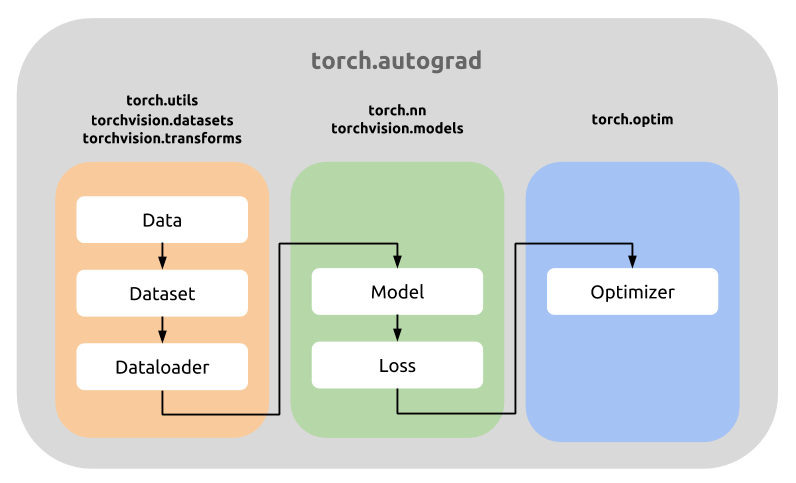

# Introduction

CIFAR10 dataset consists of 60000 32x32x3 px colour images in 10 classes. Here are some sample images from the dataset:

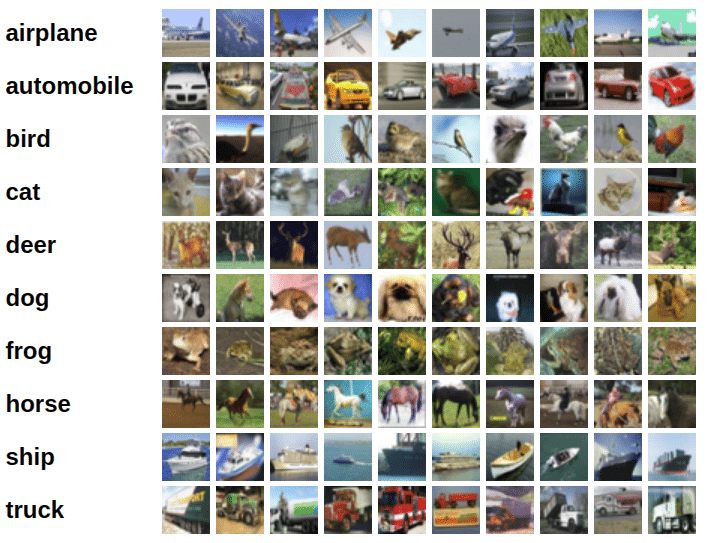

# Imports

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm
from omegaconf import OmegaConf
import torch.nn.functional as F

# Hyperparameters

In [61]:
cnf = OmegaConf.create()
cnf.download_datasets_path = "../datasets"
cnf.saved_models_path = "../saved_models"
cnf.batch_size = 64
cnf.num_epochs = 5

cnf.net = OmegaConf.create()
cnf.net.input_channels = 3
cnf.net.output_classes = 10
cnf.net.conv1_channels = 16
cnf.net.conv2_channels = 64
cnf.net.fc1_output = 360
cnf.net.fc2_output = 240

# setting the dimension of the first fc layer is a bit tricky
# we need to calculate the output of the second conv layer
# and then the input of the first fc layer
#
# the practical way is to ignore it and set it to 1
# and then run the model and see the error message
# and then set the correct value
cnf.net.fc1_input = 1
# I got the following error message:
# RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x1600 and 400x360)
# so the input of the first fc layer is 1600
cnf.net.fc1_input = 1600

In [62]:
# Determine if a GPU is available, and use it if so
# we will use it to train our model, if not we will use the CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# CIFAR-10

## Load CIFAR-10

### Preprocess CIFAR-10

In [63]:
# The first step is to load the dataset with minimal transformations
# as we want to compute the mean and standard deviation of the dataset
# to normalize the dataset
transform = transforms.Compose(
    [transforms.ToTensor()]
)  # we will use the ToTensor transformation to convert the images to tensors
# and then we will compute the mean and standard deviation of the dataset
trainset = torchvision.datasets.CIFAR10(
    root=cnf.download_datasets_path, train=True, download=True, transform=transform
)

images = torch.stack([img for img, _ in trainset], dim=0)
print(images.shape)  # [num_images, num_channels, height, width]
# we will compute the mean and standard deviation of the dataset
# note that we don't include dim=1, as we want to compute the mean and standard deviation
# for each channel separately.
means = torch.mean(images, dim=(0, 2, 3))
stds = torch.std(images, dim=(0, 2, 3))
print(means)
print(stds)

Files already downloaded and verified
torch.Size([50000, 3, 32, 32])
tensor([0.4914, 0.4822, 0.4465])
tensor([0.2470, 0.2435, 0.2616])


In [64]:
train_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean=means, std=stds),
        # TODO: Add data augmentation
    ]
)

test_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        # we use the same mean and standard deviation as for the training set
        transforms.Normalize(mean=means, std=stds),
        # no data augmentation for the test set
    ]
)

In [65]:
trainset = torchvision.datasets.CIFAR10(
    root=cnf.download_datasets_path,
    train=True,
    download=True,
    transform=train_transform,
)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=cnf.batch_size, shuffle=True, num_workers=2
)

testset = torchvision.datasets.CIFAR10(
    root=cnf.download_datasets_path,
    train=False,
    download=True,
    transform=test_transform,
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=cnf.batch_size, shuffle=False, num_workers=2
)

Files already downloaded and verified
Files already downloaded and verified


# Neural Network

In [66]:
# Define the CNN model
class CNN(nn.Module):
    def __init__(self, cnf):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=cnf.net.input_channels,
            out_channels=cnf.net.conv1_channels,
            kernel_size=5,
        )
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(
            in_channels=cnf.net.conv1_channels,
            out_channels=cnf.net.conv2_channels,
            kernel_size=5,
        )

        # should use flatten layer here

        self.fc1 = nn.Linear(
            in_features=cnf.net.fc1_input, out_features=cnf.net.fc1_output
        )
        self.fc2 = nn.Linear(
            in_features=cnf.net.fc1_output, out_features=cnf.net.fc2_output
        )
        self.fc3 = nn.Linear(
            in_features=cnf.net.fc2_output, out_features=cnf.net.output_classes
        )

    def forward(self, x):
        # [batch_size, 3, 32, 32]

        x = self.pool(F.relu(self.conv1(x)))  # 1st convolutional layer
        x = self.pool(F.relu(self.conv2(x)))  # 2nd convolutional layer

        # flatten the tensor
        x = x.view(x.size(0), -1)  # [batch_size, all_features]
        # note that the -1 is used to infer the size of the new dimension
        # this is useful if the input tensor changes size
        # for example, if we change the batch size

        x = F.relu(self.fc1(x))  # 1st fully connected layer
        x = F.relu(self.fc2(x))  # 2nd fully connected layer
        x = self.fc3(x)  # 3rd fully connected layer with no activation function

        return x

# Initialization

In [71]:
model = CNN(cnf=cnf).to(device)

In [72]:
criteria = (
    nn.CrossEntropyLoss()
)  # note that we don't use the softmax activation function
# as it is already included in the loss function
optimizer = optim.AdamW(model.parameters(), lr=0.001)

# Training the Model

In [73]:
# training the model
# use tqdm to display a progress bar
total_step = len(trainloader)
for epoch in range(cnf.num_epochs):
    running_loss = 0.0
    progress_bar = tqdm(enumerate(trainloader), total=total_step, leave=True)

    for i, data in progress_bar:

        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criteria(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        progress_bar.set_description(
            f"Epoch [{epoch+1}/{cnf.num_epochs}], Step [{i+1}/{total_step}], Loss: {loss.item():.4f}"
        )
        progress_bar.update()

Epoch [5/5], Step [782/782], Loss: 0.8830: 100%|██████████| 782/782 [00:21<00:00, 37.00it/s]


# Testing the Model

In [74]:
# testing the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in tqdm(testloader, leave=True, total=len(testloader)):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Accuracy of the model on the test images: {100 * correct / total}%")

100%|██████████| 157/157 [00:03<00:00, 42.26it/s] 

Accuracy of the model on the test images: 71.16%


# Assigment

As you can see, this model is not very good (71.16% accuracy). Your task is to improve it. You can do this by changing the architecture of the model, the hyperparameters, or the training process. You can also use data augmentation or other techniques to improve the performance of the model.

Some things to look into:
* Data Augmentation
* Batch Normalization
* Dropout
* Different architectures
* Learning Rate Scheduling
* Residual Connections
* Regularization

Take your time to experiment and try different things. It's important you develop the skills of searching the internet, and consulting eachother to find new and interesting techniques to improve your models. Good luck!

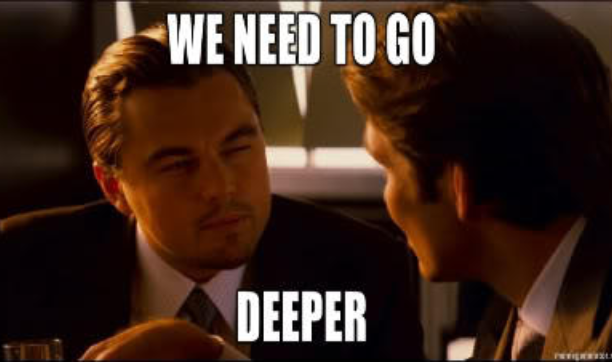